In [1]:
## Import libraries

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
data_dir=pathlib.Path('./BTD/Train_set')

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3000

In [5]:
yes=list(data_dir.glob('yes/*'))
no=list(data_dir.glob('no/*'))

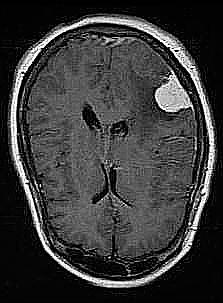

In [6]:
PIL.Image.open(str(yes[5]))

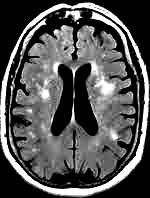

In [7]:
PIL.Image.open(str(no[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


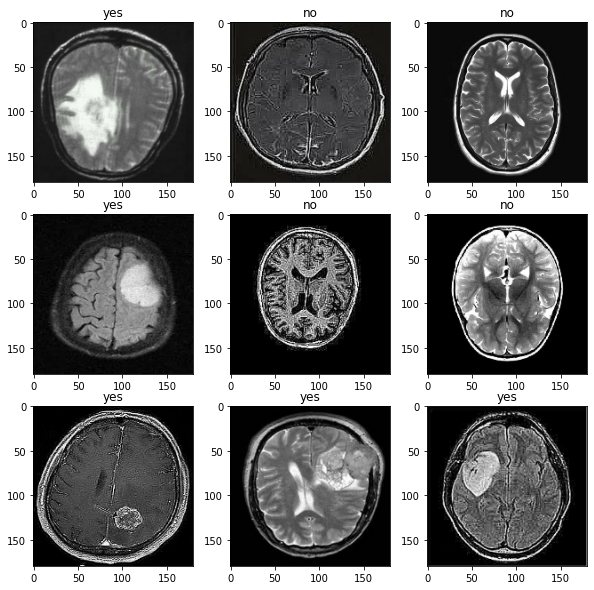

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("on")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [17]:
num_classes = len(class_names)
num_classes

2

In [18]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
for image_batch, labels_batch in train_ds:
    print(len(labels_batch))
    break

32


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [22]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 97s 1s/step - loss: 0.4735 - accuracy: 0.7646 - val_loss: 0.2901 - val_accuracy: 0.8917
Epoch 2/10
75/75 [==============================] - 100s 1s/step - loss: 0.2311 - accuracy: 0.9050 - val_loss: 0.1643 - val_accuracy: 0.9333
Epoch 3/10
75/75 [==============================] - 93s 1s/step - loss: 0.1026 - accuracy: 0.9675 - val_loss: 0.1171 - val_accuracy: 0.9667
Epoch 4/10
75/75 [==============================] - 91s 1s/step - loss: 0.0413 - accuracy: 0.9904 - val_loss: 0.1023 - val_accuracy: 0.9750
Epoch 5/10
75/75 [==============================] - 95s 1s/step - loss: 0.0329 - accuracy: 0.9904 - val_loss: 0.0876 - val_accuracy: 0.9767
Epoch 6/10
75/75 [==============================] - 101s 1s/step - loss: 0.0115 - accuracy: 0.9983 - val_loss: 0.0927 - val_accuracy: 0.9833
Epoch 7/10
75/75 [==============================] - 95s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1114 - val_accuracy: 0.9817
Epoch 8/10
75/75 [

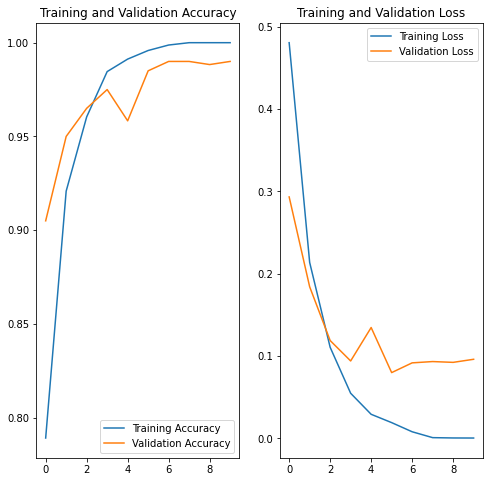

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [67]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

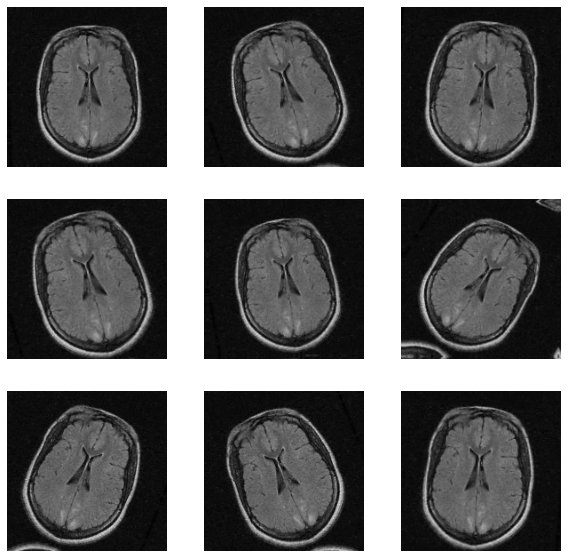

In [68]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [69]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [70]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [72]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
75/75 [==============================] - 66s 843ms/step - loss: 0.5968 - accuracy: 0.6967 - val_loss: 0.5089 - val_accuracy: 0.7750
Epoch 2/15
75/75 [==============================] - 64s 857ms/step - loss: 0.4674 - accuracy: 0.7850 - val_loss: 0.5381 - val_accuracy: 0.8017
Epoch 3/15
75/75 [==============================] - 58s 779ms/step - loss: 0.4329 - accuracy: 0.8079 - val_loss: 0.4397 - val_accuracy: 0.8300
Epoch 4/15
75/75 [==============================] - 62s 827ms/step - loss: 0.3762 - accuracy: 0.8233 - val_loss: 0.3244 - val_accuracy: 0.8800
Epoch 5/15
75/75 [==============================] - 65s 864ms/step - loss: 0.3470 - accuracy: 0.8596 - val_loss: 0.2514 - val_accuracy: 0.8917
Epoch 6/15
75/75 [==============================] - 64s 852ms/step - loss: 0.3276 - accuracy: 0.8596 - val_loss: 0.2256 - val_accuracy: 0.9183
Epoch 7/15
75/75 [==============================] - 66s 876ms/step - loss: 0.2897 - accuracy: 0.8725 - val_loss: 0.2003 - val_accuracy: 0.9167

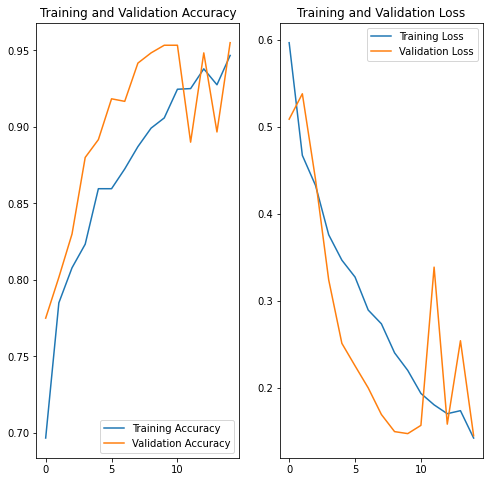

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

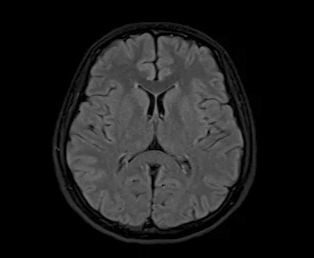

In [25]:
test_dir=pathlib.Path('./BTD/input/pred/pred0.jpg')
img = tf.keras.utils.load_img(
    test_dir, target_size=(img_height, img_width)
)
PIL.Image.open(str(test_dir))

In [26]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to no with a 99.97 percent confidence.
